In [159]:
import os
import torch
from torch import nn
from torchvision.models.detection import ssd300_vgg16
import torchvision as tv
from torchvision.transforms import v2, transforms, ToPILImage
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import time
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import defaultdict
import xml.etree.ElementTree as ET
import cv2
from PIL import Image
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
import warnings
import seaborn as sns
from IPython import display
import torchvision.ops as ops
from random import choice
import matplotlib.patches as patches

%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f' Device: {torch.cuda.get_device_name(0)}. Now using: {device.type}', '\n',
      f'Torch Version: {torch.version.__version__}')

 Device: NVIDIA GeForce RTX 4070 Ti. Now using: cuda 
 Torch Version: 2.2.1


In [3]:
os.chdir(r'E:\python_projects\notebooks\Deep learning\Deep learning homeworks\HW 8')

In [4]:
bccd_root = r'E:\python_projects\notebooks\Deep learning\Deep learning homeworks\HW 8\BCCD_Dataset'

In [5]:
num_classes = 4
model_pt = ssd300_vgg16(weights="DEFAULT")
model = ssd300_vgg16(weights=None, num_classes=num_classes)

backbone_state_dict = {k: v for k, v in model_pt.backbone.state_dict().items()}
model.backbone.load_state_dict(backbone_state_dict)

for param in model.backbone.parameters(): 
    param.requires_grad = False

In [6]:
for module in model.head.classification_head.modules():
    if isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)

for module in model.head.regression_head.modules():
    if isinstance(module, nn.Conv2d):
        nn.init.xavier_uniform_(module.weight)
        nn.init.zeros_(module.bias)

In [8]:
b_boxes_df = pd.read_csv(bccd_root + '\\test.csv')
len(b_boxes_df)

4888

In [137]:
b_boxes_df

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336
3,BloodImage_00000.jpg,RBC,214,320,362,461
4,BloodImage_00000.jpg,RBC,414,506,352,445
...,...,...,...,...,...,...
4883,BloodImage_00410.jpg,Platelets,239,291,275,321
4884,BloodImage_00410.jpg,Platelets,121,189,260,320
4885,BloodImage_00410.jpg,Platelets,57,104,119,167
4886,BloodImage_00410.jpg,Platelets,1,29,286,327


In [9]:
invalid_boxes = b_boxes_df[(b_boxes_df['xmin'] >= b_boxes_df['xmax']) |
                   (b_boxes_df['ymin'] >= b_boxes_df['ymax']) |
                   (b_boxes_df['xmin'] < 0) |
                   (b_boxes_df['ymin'] < 0)]

df_filtered = b_boxes_df[~b_boxes_df['filename'].isin(invalid_boxes['filename'])]
len(df_filtered)


4862

In [10]:
class BCCD_Dataset(Dataset):
    def __init__(self, root, dataframe, transforms=None):
        self.images_dir = "\\BCCD\\JPEGImages\\"
        self.root = root
        self.transforms = transforms      
        self.annot_df = dataframe
        self.imagelist = list(self.annot_df['filename'].unique())
        self.labels_dict = {label: idx+1 for idx, label in enumerate(self.annot_df['cell_type'].unique())}

    def __getitem__(self, idx):
        
        img_path = self.root + self.images_dir + self.imagelist[idx]
        img = Image.open(img_path).convert("RGB")
        original_width, original_height = img.size
        img_objects_df = self.annot_df.loc[self.annot_df['filename'] == self.imagelist[idx]]
        num_objs = len(img_objects_df)
        
        boxes = []
        labels_indexes = []
        for i in range(num_objs):
            xmin = img_objects_df.iloc[i].xmin
            xmax = img_objects_df.iloc[i].xmax
            ymin = img_objects_df.iloc[i].ymin
            ymax = img_objects_df.iloc[i].ymax
            label = img_objects_df.iloc[i].cell_type
            boxes.append([xmin, ymin, xmax, ymax])
            labels_indexes.append(self.labels_dict[label])
          
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels_indexes, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        if self.transforms is not None:
            img = self.transforms(img)
            width_scale = 300 / original_width
            height_scale = 300 / original_height
            boxes[:, [0, 2]] *= width_scale 
            boxes[:, [1, 3]] *= height_scale
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area

        return img, target

    def __len__(self):
        return len(self.imagelist)

In [11]:
obj_transforms = v2.Compose([
                            v2.Resize((300, 300)), 
                            v2.ToImage(), 
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], 
                            std=[0.229, 0.224, 0.225])
                            ]
                                                         
                                                         )

img, target = BCCD_Dataset(bccd_root, df_filtered, transforms=obj_transforms)[0]
target = {k: v.to(device) for k, v in target.items()}

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 11], gamma=0.1)

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

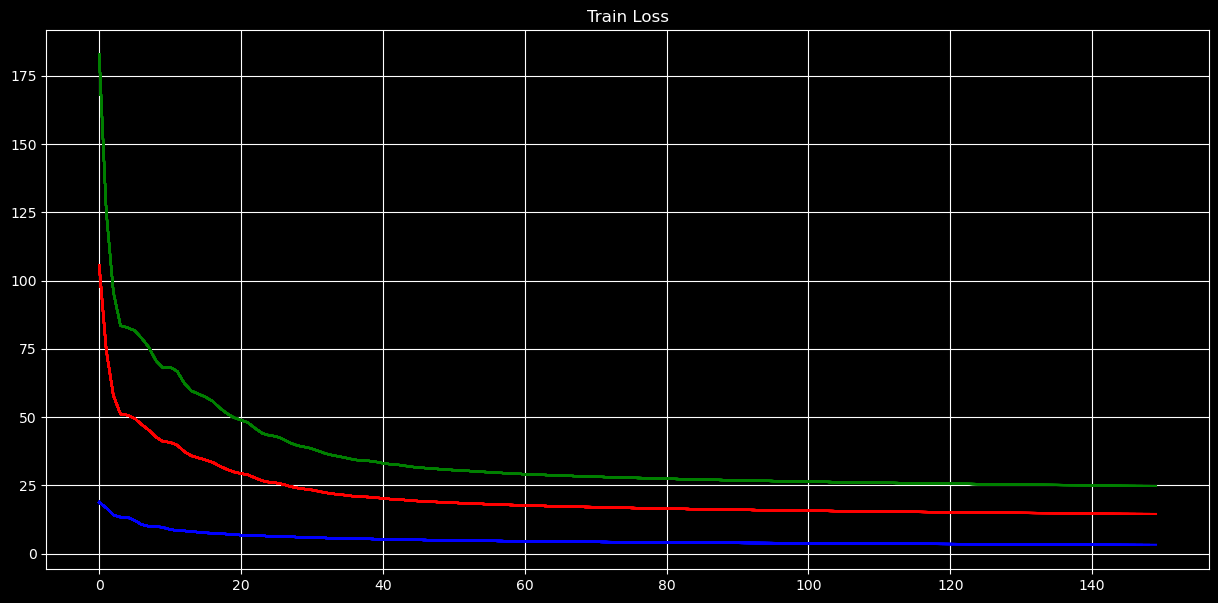

Epoch 149 -- Epoch Loss: 14.5058 -- Classifier Loss: 24.7588 -- Regressor Loss: 3.2285 -- Learning Rate: 0.000500 -- Time: 5.18s


In [14]:
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(15, 7))
ax.set_title('Train Loss')
ax.grid()
classifier_weight = 0.7
regressor_weight = 0.3

dataset = BCCD_Dataset(root = bccd_root, dataframe=df_filtered, transforms=obj_transforms)
classifier_losses = []
regressor_losses = []
total_losses = []
model.to(device)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

for ep in range(150):
    start = time.time()
    epoch_total_loss = 0
    epoch_cls_loss = 0
    epoch_reg_loss = 0
    for images, targets in dataloader_train:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        losses = model(images, targets)
        epoch_cls_loss += (losses['classification'] * classifier_weight)
        epoch_reg_loss += (losses['bbox_regression'] * regressor_weight)
        step_total_loss = epoch_cls_loss + epoch_reg_loss
        epoch_total_loss += step_total_loss
    
    epoch_total_loss = epoch_total_loss / len(dataloader_train)
    # epoch_cls_loss = epoch_cls_loss / len(dataloader_train)
    # epoch_reg_loss = epoch_reg_loss / len(dataloader_train)
    optimizer.zero_grad()
    epoch_total_loss.backward()
    optimizer.step()
    # lr_scheduler.step()
    
    classifier_losses.append(epoch_cls_loss.item())
    regressor_losses.append(epoch_reg_loss.item())
    total_losses.append(epoch_total_loss.item())

    last_lr = optimizer.param_groups[0]['lr']

    sns.lineplot(total_losses, c='red', ax = ax)
    sns.lineplot(classifier_losses, c='green', ax = ax)
    sns.lineplot(regressor_losses, c='blue', ax = ax)
    display.display(fig, clear=True)
    plt.close()

    print(f'Epoch {ep} -- Epoch Loss: {epoch_total_loss:.4f} -- Classifier Loss: {epoch_cls_loss:.4f} -- Regressor Loss: {epoch_reg_loss:.4f} -- Learning Rate: {last_lr:.6f} -- Time: {time.time() - start:.2f}s')

In [64]:
test_img, test_prop = choice(test_dataset)

In [160]:
def show_bb_boxes(image, coordinates, ax):
    image = image.cpu().detach()
    image = image.permute(1, 2, 0)
    bboxes = coordinates['boxes'].cpu().numpy()
    labels = coordinates['labels'].cpu().numpy()
    # fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image)
    for box, label in zip(bboxes, labels):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)   
        ax.text(x_min, y_min - 5, f'Class {label}', color='red', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    ax.axis("off")
    # plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


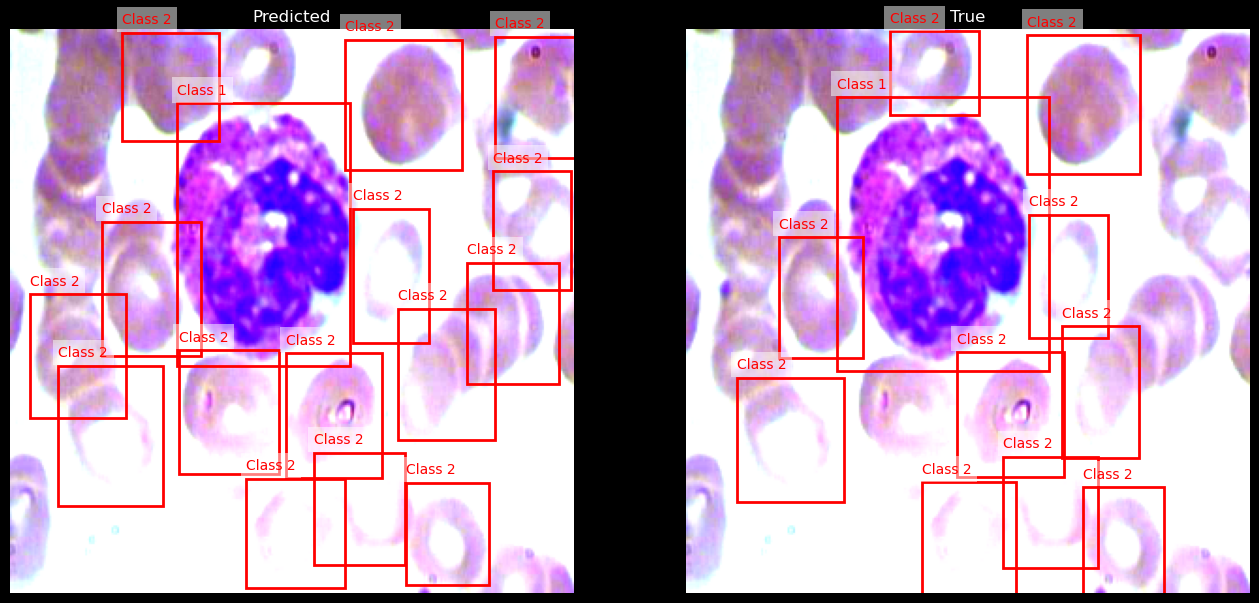

In [167]:
test_img, test_coordinates = choice(test_dataset)
with torch.no_grad():
    model.eval()
    model_coordinates = model(test_img.unsqueeze(0).to(device))

threshold = 0.35
model_coordinates = model_coordinates[0]
keep = model_coordinates['scores'] > threshold

filtered_coordinates = {
    'boxes': model_coordinates['boxes'][keep],
    'labels': model_coordinates['labels'][keep],
    'scores': model_coordinates['scores'][keep]
}

nms_keep = ops.nms(filtered_coordinates['boxes'], filtered_coordinates['scores'], iou_threshold=0.33)

final_coordinates = {
    'boxes': filtered_coordinates['boxes'][nms_keep],
    'labels': filtered_coordinates['labels'][nms_keep]
}

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

show_bb_boxes(test_img, final_coordinates, ax[0])
ax[0].set_title('Predicted')

show_bb_boxes(test_img, test_coordinates, ax[1])
ax[1].set_title('True')

plt.show()
